In [1]:
from knn_chain import knn_chain

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.io import mmread, loadmat

# Time complexity analysis packages
import pstats, cProfile
import pyximport
pyximport.install()

# Memory complexity analysis packages
import tracemalloc

# Datasets
import tensorflow as tf

2024-09-01 14:56:16.515476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 14:56:16.533344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 14:56:16.538794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-01 14:56:16.553909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 14:56:18.118018: W tensorflow/compiler/tf2

# FUNCTIONS

In [2]:
def record_runtimes(X, ks, n = 10):
    
    avgs = []
    for k in ks:
        avg = 0.0
        for i in range(n):
            cProfile.runctx("knn_chain(X, k)", globals(), locals(), "Profile.prof")
            k1 = pstats.Stats("Profile.prof")
            avg += k1.strip_dirs().sort_stats("time").total_tt

        avg = avg/n
        avgs.append(avg)
        print(f"avg, k = {k} = {avg}")

    return avgs

In [3]:
def plot_runtimes(ks, avgs):
    str_ks = list(map(str, ks))
    
    plt.figure(figsize=(10, 6))
    plt.plot(str_ks, avgs, marker='o', c = '#D81B60', alpha=0.7)

    for i, avg in enumerate(avgs):
        plt.text(str_ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=10, color='#000000', fontweight='bold')

    plt.title("Execution time comparison")
    plt.xlabel("Value of k")
    plt.xticks(ticks=str_ks, labels=str_ks) 
    plt.ylabel("Execution time in seconds")
    plt.grid(c = "#d3d3d3")

    margin = 1.3
    plt.xlim(min(ks) - margin, max(ks) + margin)

    plt.show()

In [4]:
def plot_all_runtimes(times, ks, titles, label_indices):
    n = len(titles)
    colours = ['#FFB000', '#FE6100', '#DC267F', '#785EF0', '#648FFF']
    
    fig, axes = plt.subplots(1, n, figsize=(25, 5), sharex=False, sharey=False)
    margin = 2.2

    for i in range(n):
        axes[i].plot(ks, times[i], marker='o', color=colours[i])

        for j, avg in enumerate( times[i]):
            if j == label_indices[i]:
                axes[i].text(ks[j], avg, f'{avg:.4f}', ha='center', va='top', fontsize=16, color='#000000', fontweight='bold')
            else:
                axes[i].text(ks[j], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=16, color='#000000', fontweight='bold')

        axes[i].set_title(titles[i], fontsize=23)
        axes[i].set_xlabel('k', fontsize=19)
        axes[i].set_ylabel('Average Runtime (s)', fontsize=19)
        axes[i].grid(c = "#d3d3d3")
        axes[i].set_xlim([min(ks) - margin, max(ks) + margin])

    plt.tight_layout()
    plt.show()

In [5]:
def aux_set_axis_limits(ax, y):
    ax.set_ylim([min(y) - 100, max(y) + 100])
    ax.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}')) 

def plot_mem(mems, ks, titles):
    str_ks = list(map(str, ks))
    n = len(titles)
    colours = ['#FFB000', '#FE6100', '#DC267F', '#785EF0', '#648FFF']

    fig, axes = plt.subplots(1, n, figsize=(25, 5), sharex=False, sharey=False)
    bar_width = 0.7

    for i in range(n):
        axes[i].bar(str_ks, mems[i], color=colours[i], width=bar_width)
        axes[i].set_title(titles[i], fontsize=23)
        axes[i].set_xlabel('k', fontsize=19)
        axes[i].set_ylabel('Average Memory Consumption', fontsize=19)
        axes[i].grid(c="#d3d3d3")
        aux_set_axis_limits(axes[i], mems[i])
    
    plt.tight_layout()
    plt.show()

# VARIABLES

In [6]:
n = 20
ks = [1, 3, 6, 10, 15]

# Dataset Visualisation

## 1. Synthetic Dataset

In [ ]:
s_X = np.loadtxt("datasets/generated_smallX")
med_X = np.loadtxt("datasets/generated_mediumX")
large_X = np.loadtxt("datasets/generated_largeX")
xl_X = np.loadtxt("datasets/generated_xlargeX")
xxl_X = np.loadtxt("datasets/generated_xxlargeX")

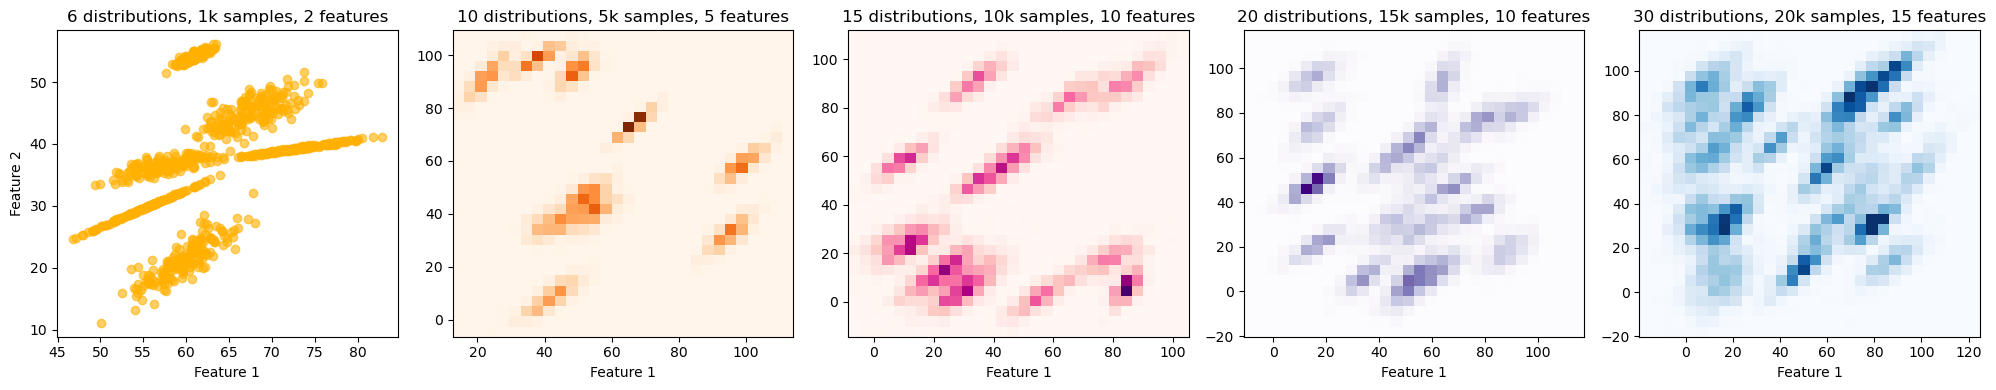

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=False, sharey=False)

# Plot for small_X
axes[0].scatter(s_X[:, 0], s_X[:, 1], alpha=0.6, c='#FFB000')
axes[0].set_title('6 distributions, 1k samples, 2 features')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Plot for med_X
axes[1].hist2d(med_X[:, 0], med_X[:, 1], bins=30, cmap='Oranges')
axes[1].set_title('10 distributions, 5k samples, 5 features')
axes[1].set_xlabel('Feature 1')

# Plot for large_X
axes[2].hist2d(large_X[:, 0], large_X[:, 1], bins=30, cmap='RdPu')
axes[2].set_title('15 distributions, 10k samples, 10 features')
axes[2].set_xlabel('Feature 1')

# Plot for xlarge_X
axes[3].hist2d(xl_X[:, 0], xl_X[:, 1], bins=30, cmap='Purples')
axes[3].set_title('20 distributions, 15k samples, 10 features')
axes[3].set_xlabel('Feature 1')

# Plot for xxlarge_X
axes[4].hist2d(xxl_X[:, 0], xxl_X[:, 1], bins=30, cmap='Blues')
axes[4].set_title('30 distributions, 20k samples, 15 features')
axes[4].set_xlabel('Feature 1')

# Adjust layout
plt.tight_layout()
plt.show()

## 2. MNIST

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
n_images = x_train.shape[0]
X_images = x_train.reshape(n_images, 28, 28)
mnist_data = X_images.reshape(n_images, 28 * 28)

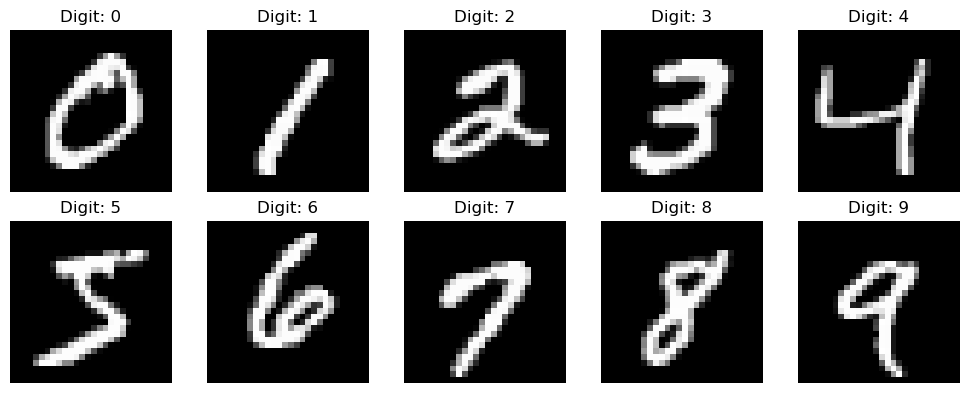

In [ ]:
plt.figure(figsize=(10, 4))

for digit in range(10):
    index = (y_train == digit).nonzero()[0][0]
    plt.subplot(2, 5, digit + 1)
    plt.imshow(x_train[index], cmap='gray')
    plt.title(f'Digit: {digit}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# EXPERIMENTS

## Time Complexity

## 1. small X

In [7]:
s_X = np.loadtxt("datasets/generated_smallX")
avgs_small_gen = record_runtimes(s_X, ks, n)

avg, k = 1 = 0.023073007149999998
avg, k = 3 = 0.020707604999999997
avg, k = 6 = 0.02090086905
avg, k = 10 = 0.019453448899999996
avg, k = 15 = 0.023112335750000004


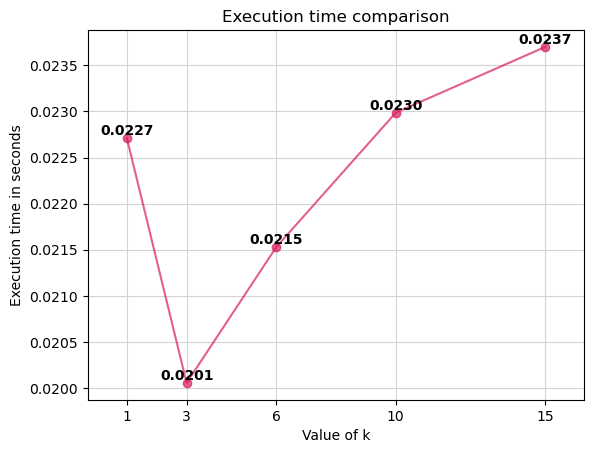

In [ ]:
plot_runtimes(ks, avgs_small_gen)

## 2. medium X

avg, k = 1 = 0.71488068785
avg, k = 3 = 0.5917478258
avg, k = 6 = 0.54107109315
avg, k = 10 = 0.55368558045
avg, k = 15 = 0.56659320355


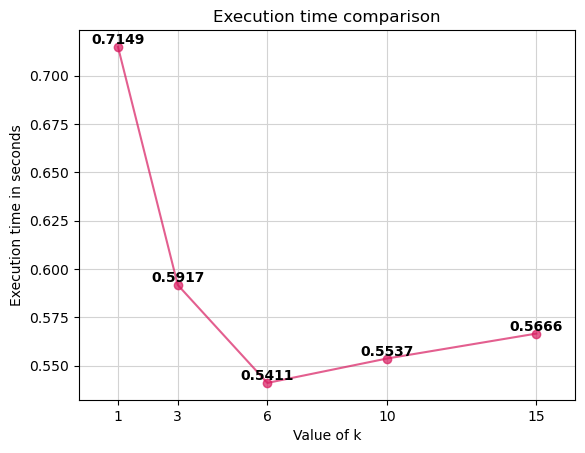

In [ ]:
med_X = np.loadtxt("datasets/generated_mediumX")
avgs_med_gen = record_runtimes(med_X, ks, n)
plot_runtimes(ks, avgs_med_gen)

## 3. large X

avg, k = 1 = 2.9384835022999996
avg, k = 3 = 2.25442247965
avg, k = 6 = 2.1617690972500005
avg, k = 10 = 2.1651844017500004
avg, k = 15 = 2.2024546772500004


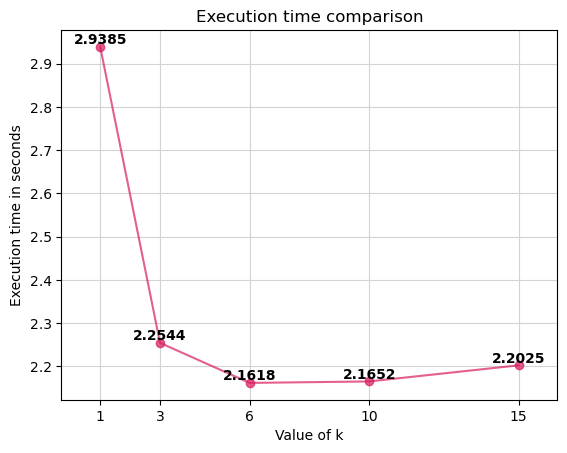

In [ ]:
large_X = np.loadtxt("datasets/generated_largeX")
avgs_large_gen = record_runtimes(large_X, ks, n)
plot_runtimes(ks, avgs_large_gen)

## 4. extra large X

avg, k = 1 = 6.957992400250001
avg, k = 3 = 5.30109754025
avg, k = 6 = 4.93085242195
avg, k = 10 = 4.899931189000001
avg, k = 15 = 4.974749849949999


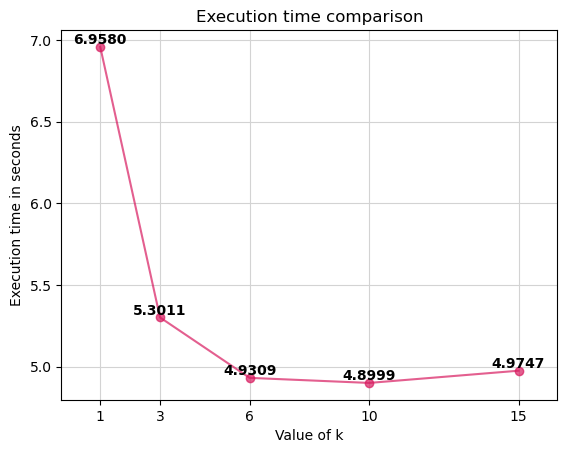

In [ ]:
xl_X = np.loadtxt("datasets/generated_xlargeX")
avgs_xl_gen = record_runtimes(xl_X, ks, n)
plot_runtimes(ks, avgs_xl_gen)

## 5. extra extra large X

avg, k = 1 = 14.521160413500002
avg, k = 3 = 10.91834577565
avg, k = 6 = 11.64719696605
avg, k = 10 = 10.653050424649999
avg, k = 15 = 10.572595866099999


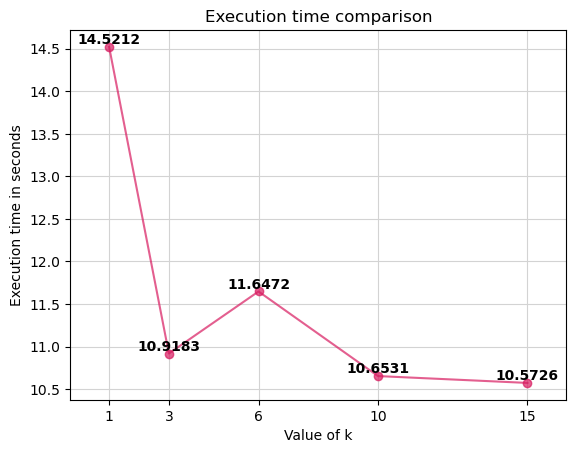

In [ ]:
xxl_X = np.loadtxt("datasets/generated_xxlargeX")
avgs_xxl_gen = record_runtimes(xxl_X, ks, n)
plot_runtimes(ks, avgs_xxl_gen)

In [1]:
# reload results
avgs_small_gen = [0.02270951125, 0.020055988150000002, 0.02152903665, 0.022986338100000003, 0.0236995462]
avgs_med_gen = [0.71488068785, 0.5917478258, 0.54107109315, 0.55368558045, 0.56659320355]
avgs_large_gen = [2.9384835022999996, 2.25442247965, 2.1617690972500005, 2.1651844017500004, 2.2024546772500004]
avgs_xl_gen = [6.957992400250001, 5.30109754025, 4.93085242195, 4.899931189000001, 4.974749849949999]
avgs_xxl_gen = [14.521160413500002, 10.91834577565, 11.64719696605, 10.653050424649999, 10.572595866099999]

## All of the values in one plot

In [9]:
titles = ['Synthetic Dataset 1','Synthetic Dataset 2','Synthetic Dataset 3','Synthetic Dataset 4','Synthetic Dataset 5']
all_syn_avgs = [[0.02270951125, 0.020055988150000002, 0.02152903665, 0.022986338100000003, 0.0236995462], [0.71488068785, 0.5917478258, 0.54107109315, 0.55368558045, 0.56659320355], [2.9384835022999996, 2.25442247965, 2.1617690972500005, 2.1651844017500004, 2.2024546772500004], [6.957992400250001, 5.30109754025, 4.93085242195, 4.899931189000001, 4.974749849949999], [14.521160413500002, 10.91834577565, 11.64719696605, 10.653050424649999, 10.572595866099999]]
label_indices = [len(all_syn_avgs[0])-1, 0,0,0,0]

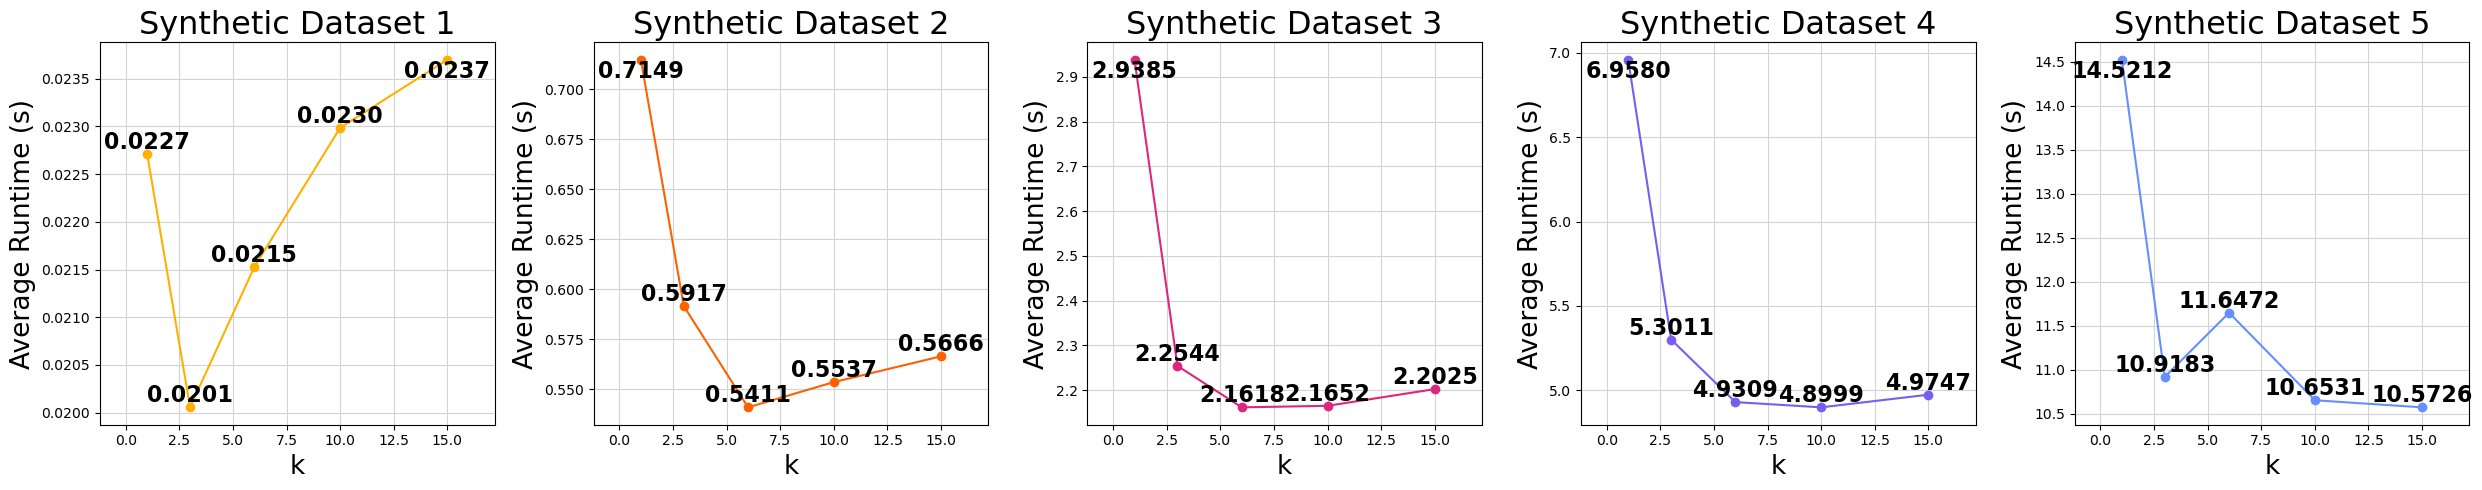

In [10]:
plot_all_runtimes(all_syn_avgs, ks, titles, label_indices)

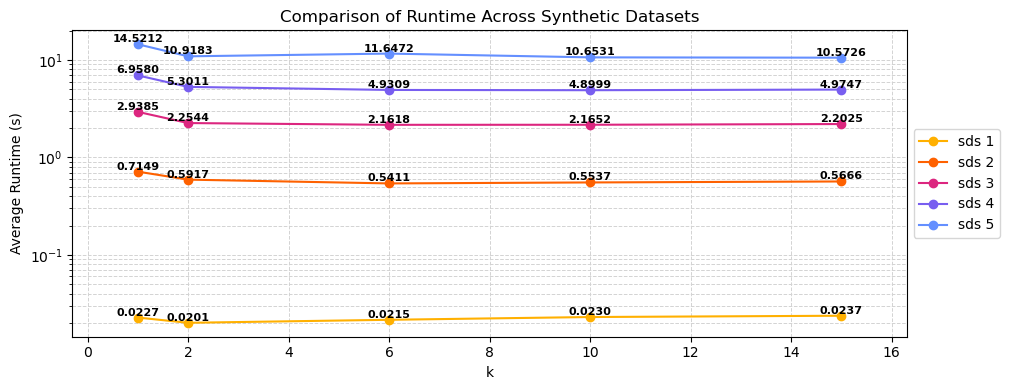

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
margin = 1.3

ax.plot(ks, avgs_small_gen, marker='o', color='#FFB000', label='sds 1')
for i, avg in enumerate(avgs_small_gen):
    ax.text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=8, color='#000000', fontweight='bold')

ax.plot(ks, avgs_med_gen, marker='o', color='#FE6100', label='sds 2')
for i, avg in enumerate(avgs_med_gen):
    ax.text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=8, color='#000000', fontweight='bold')

ax.plot(ks, avgs_large_gen, marker='o', color='#DC267F', label='sds 3')
for i, avg in enumerate(avgs_large_gen):
    ax.text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=8, color='#000000', fontweight='bold')

ax.plot(ks, avgs_xl_gen, marker='o', color='#785EF0', label='sds 4')
for i, avg in enumerate(avgs_xl_gen):
    ax.text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=8, color='#000000', fontweight='bold')

ax.plot(ks, avgs_xxl_gen, marker='o', color='#648FFF', label='sds 5')
for i, avg in enumerate(avgs_xxl_gen):
    ax.text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=8, color='#000000', fontweight='bold')

ax.set_title('Comparison of Runtime Across Synthetic Datasets')
ax.set_xlabel('k')
ax.set_ylabel('Average Runtime (s)')

ax.set_yscale('log')
ax.set_xlim([min(ks) - margin, max(ks) + margin])
ax.grid(visible=True, which='both', color='#d3d3d3', linestyle='--', linewidth=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

## 6. MNIST

In [ ]:
big_ks = [20, 25, 30, 35, 40, 45, 50, 90]

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
n_images = x_train.shape[0]
X_images = x_train.reshape(n_images, 28, 28)
mnist_data = X_images.reshape(n_images, 28 * 28)

In [ ]:
avgs_mnist = record_runtimes(mnist_data[:10000], ks, n=10)

avg, k = 1 = 134.679089794
avg, k = 3 = 99.6309402132
avg, k = 6 = 93.06807508450001
avg, k = 10 = 91.56076789950001
avg, k = 15 = 91.1540667678


In [ ]:
avgs_mnist2 = record_runtimes(mnist_data[:10000], big_ks, n=20)

avg, k = 20 = 95.3777787457
avg, k = 25 = 96.1306362852
avg, k = 30 = 93.4256124142
avg, k = 35 = 89.2346406435
avg, k = 40 = 87.8367767529
avg, k = 45 = 90.73774779850001
avg, k = 50 = 90.23323753160001
avg, k = 90 = 101.18906989030003


In [ ]:
mnist_avgs = [134.4364607491, 98.23908929675, 92.00315058255, 90.59960501945, 89.74421718010001, 95.3777787457, 96.1306362852, 93.4256124142, 89.2346406435, 87.8367767529, 90.73774779850001, 90.23323753160001, 101.18906989030003]
mnist_avgs = [134.4364607491, 98.23908929675, 89.74421718010001, 96.1306362852, 89.2346406435]

## 7. BBC News

In [ ]:
matrix = mmread('datasets/bbc.mtx')
bbc_matrix = matrix.toarray().transpose() # max = 81.0

In [ ]:
avgs_bbc = record_runtimes(bbc_matrix, ks, n=20)

avg, k = 1 = 59.207046035750025
avg, k = 3 = 44.2037801331
avg, k = 6 = 41.284789821500006
avg, k = 10 = 40.476090429900005
avg, k = 15 = 40.152519741099994


In [ ]:
avgs_bbc2 = record_runtimes(bbc_matrix, big_ks, n=20)

avg, k = 20 = 40.99965332095
avg, k = 25 = 40.86750714674999
avg, k = 30 = 40.8883387581
avg, k = 35 = 40.6200202031
avg, k = 40 = 40.62088328045
avg, k = 45 = 40.412292672250004
avg, k = 50 = 40.4469395618
avg, k = 90 = 40.2599467756


In [ ]:
bbc_avgs = [59.207046035750025, 44.2037801331, 41.284789821500006, 40.476090429900005, 40.152519741099994, 40.99965332095, 40.86750714674999, 40.8883387581, 40.6200202031, 40.62088328045, 40.412292672250004, 40.4469395618, 40.2599467756]
bbc_avgs = [59.207046035750025, 44.2037801331, 40.152519741099994, 40.86750714674999, 40.6200202031]

## 3. Adult

In [7]:
adult = np.loadtxt("datasets/adult_train.data")
adult = np.nan_to_num(adult)

In [21]:
avgs_adult = record_runtimes(adult, [1, 3, 15, 25, 35], n=20)
# k = 1 =  58.5837409584
# k = 3 =  42.51337018620001
# k = 15 = 38.880244059350005
# k = 25 = 40.5786839207
# k = 35 = 40.711834972700004

k = 1 = 58.5837409584
k = 3 = 42.51337018620001
k = 15 = 38.880244059350005
k = 25 = 40.5786839207
k = 35 = 40.711834972700004


In [22]:
adult_avgs = [58.5837409584, 42.51337018620001, 38.880244059350005, 40.5786839207, 40.711834972700004]

## Plotting all Real datasets

In [25]:
new_ks = [1, 3, 15, 25, 35]

In [26]:
titles = ['MNIST','BBC News','Adult']
all_real_avgs = [[134.4364607491, 98.23908929675, 89.74421718010001, 96.1306362852, 89.2346406435], [59.207046035750025, 44.2037801331, 40.152519741099994, 40.86750714674999, 40.6200202031], [58.5837409584, 42.51337018620001, 38.880244059350005, 40.5786839207, 40.711834972700004]]
label_indices = [0,0,0]

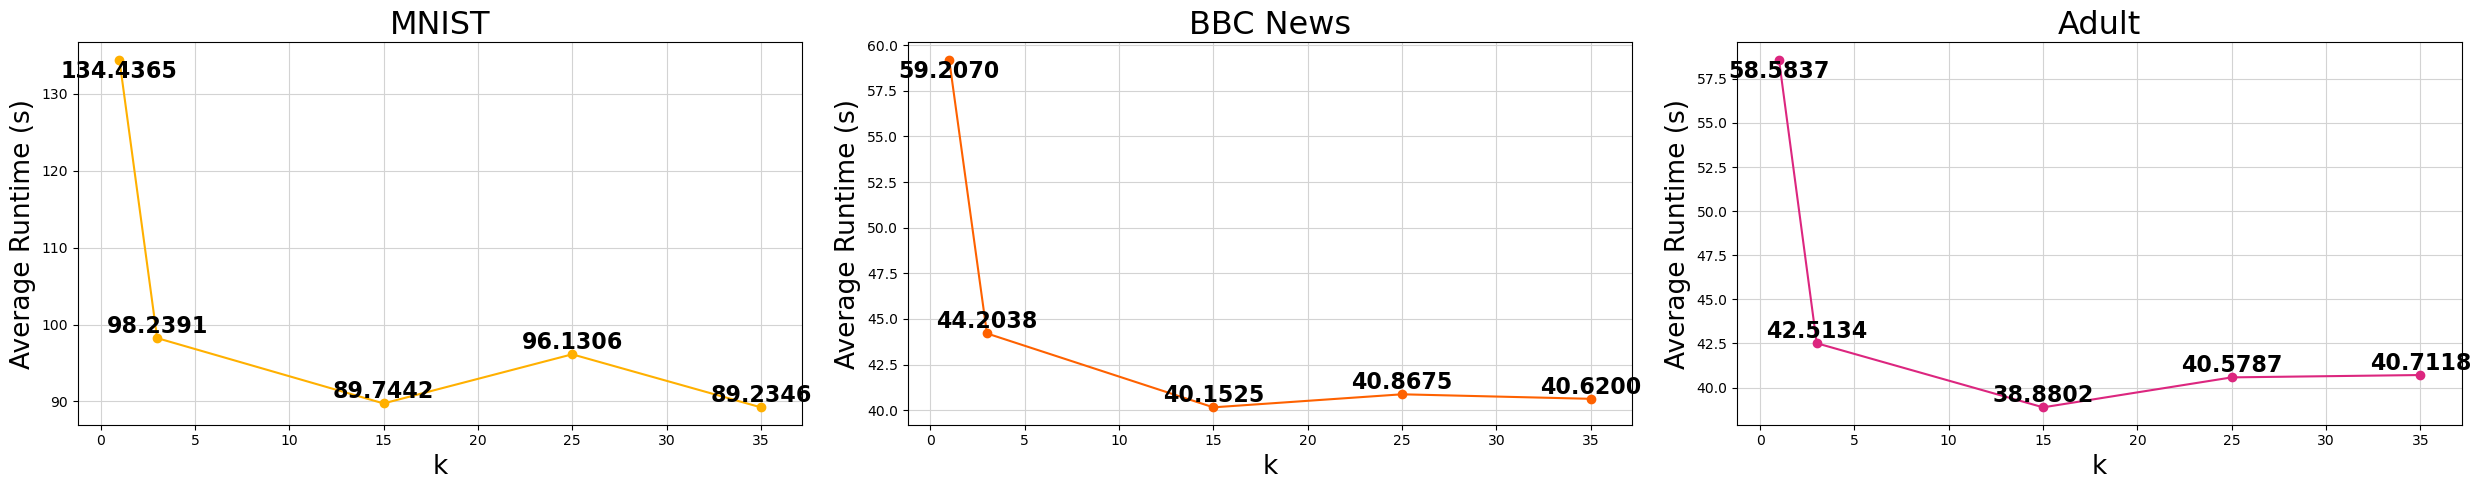

In [27]:
plot_all_runtimes(all_real_avgs, new_ks, titles, label_indices)

## Memory Complexity

In [11]:
def record_memory(X, ks):
    mem = []
    for k in ks:
        tracemalloc.start()
        knn_chain(X, k)
        mem.append(tracemalloc.get_traced_memory()[1])
        tracemalloc.stop()
    return np.array(mem)

In [12]:
def wrapper_mem(X, ks, n):
    mem = np.zeros(len(ks))
    for _ in range(n):
        mem = mem + record_memory(X, ks)
    return mem/n

### Generated, synthetic data

In [ ]:
s_X = np.loadtxt("datasets/generated_smallX")
med_X = np.loadtxt("datasets/generated_mediumX")
large_X = np.loadtxt("datasets/generated_largeX")
xl_X = np.loadtxt("datasets/generated_xlargeX")
xxl_X = np.loadtxt("datasets/generated_xxlargeX")

In [ ]:
s_mem = wrapper_mem(s_X, ks, n)
print(s_mem)

[184541.8  184213.2  184216.   184242.95 184216.  ]


In [ ]:
med_mem = wrapper_mem(med_X, ks, n)
print(med_mem)

[953196.7 953115.5 952987.2 953132.6 953072.4]


In [ ]:
large_mem = wrapper_mem(large_X, ks, n)
print(large_mem)

[1911940.35 1911668.1  1911647.4  1911589.3  1911665.4 ]


In [ ]:
xl_mem = wrapper_mem(xl_X, ks, n)
print(xl_mem)

[2873553.65 2873393.2  2873319.4  2873440.8  2873339.2 ]


In [ ]:
xxl_mem = wrapper_mem(xxl_X, ks, n)
print(xxl_mem)

[3830062.95 3829777.75 3829846.4  3829931.6  3829910.8 ]


In [20]:
s_mem = [184541.8,  184213.2,  184216.,   184242.95, 184216.]
med_mem = [953196.7, 953115.5, 952987.2, 953132.6, 953072.4]
large_mem = [1911940.35, 1911668.1, 1911647.4, 1911589.3, 1911665.4]
xl_mem = [2873553.65, 2873393.2, 2873319.4, 2873440.8, 2873339.2]
xxl_mem = [3830062.95, 3829777.75, 3829846.4, 3829931.6, 3829910.8]
syn_mems = [s_mem, med_mem, large_mem, xl_mem, xxl_mem]

In [22]:
titles = ['Synthetic Dataset 1','Synthetic Dataset 2','Synthetic Dataset 3','Synthetic Dataset 4','Synthetic Dataset 5']

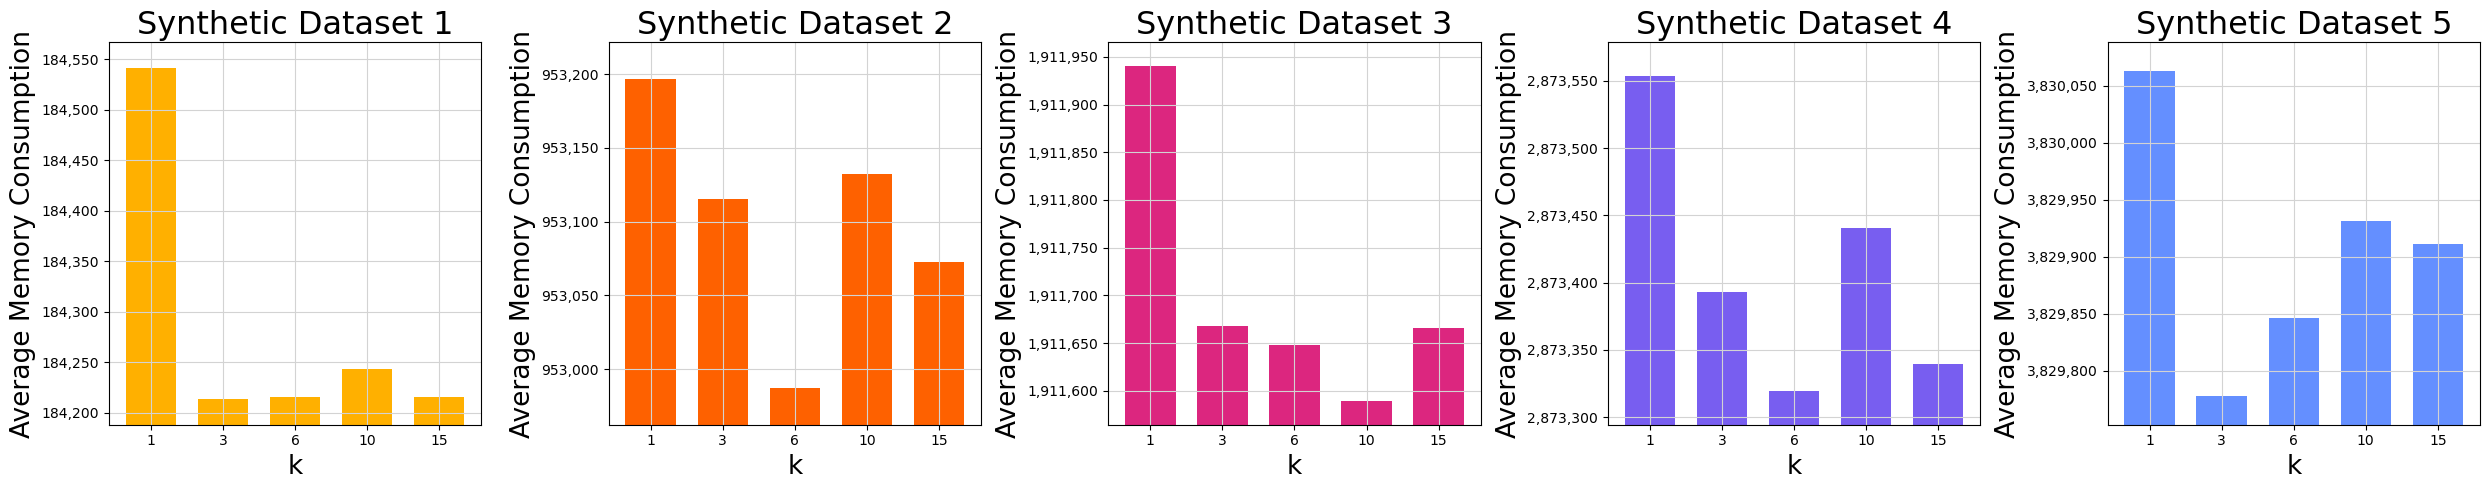

In [25]:
plot_mem(syn_mems, ks, titles)

## Real world datasets

In [7]:
# MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
n_images = x_train.shape[0]
X_images = x_train.reshape(n_images, 28, 28)
mnist_data = X_images.reshape(n_images, 28 * 28)
# BBC News
matrix = mmread('datasets/bbc.mtx')
bbc_matrix = matrix.toarray().transpose() # max = 81.0
# Adult Census
adult = np.loadtxt("datasets/adult_train.data")
adult = np.nan_to_num(adult)

In [8]:
new_ks = [1, 3, 15, 25, 35]

In [26]:
mnist_mem =[1917489.5, 1917497.9, 1916723.9, 1917454.9, 1916837.8]

In [29]:
mnist_mem = wrapper_mem(mnist_data[:10000], new_ks, 20)
print(mnist_mem)

[1917489.5, 1917497.9, 1916723.9, 1917454.9, 1916837.8]


In [27]:
bbc_mem = [424236.1, 421231.4, 420822.0, 421064.3, 421617.0]

In [21]:
bbc_mem = wrapper_mem(bbc_matrix, new_ks, 20)
print(bbc_mem)

[424236.1, 421231.4, 420822.0, 421064.3, 421617.0]


In [23]:
adult_mem = [6559781.2, 6559037.6, 6558624.5, 6559455.0, 6560133.8]

In [24]:
adult_mem = wrapper_mem(adult, new_ks, 20)
print(adult_mem)

[6559781.2, 6559037.6, 6558624.5, 6559455.0, 6560133.8]


In [28]:
real_mems = [mnist_mem, bbc_mem, adult_mem]
titles = ['MNIST','BBC News','Adult']

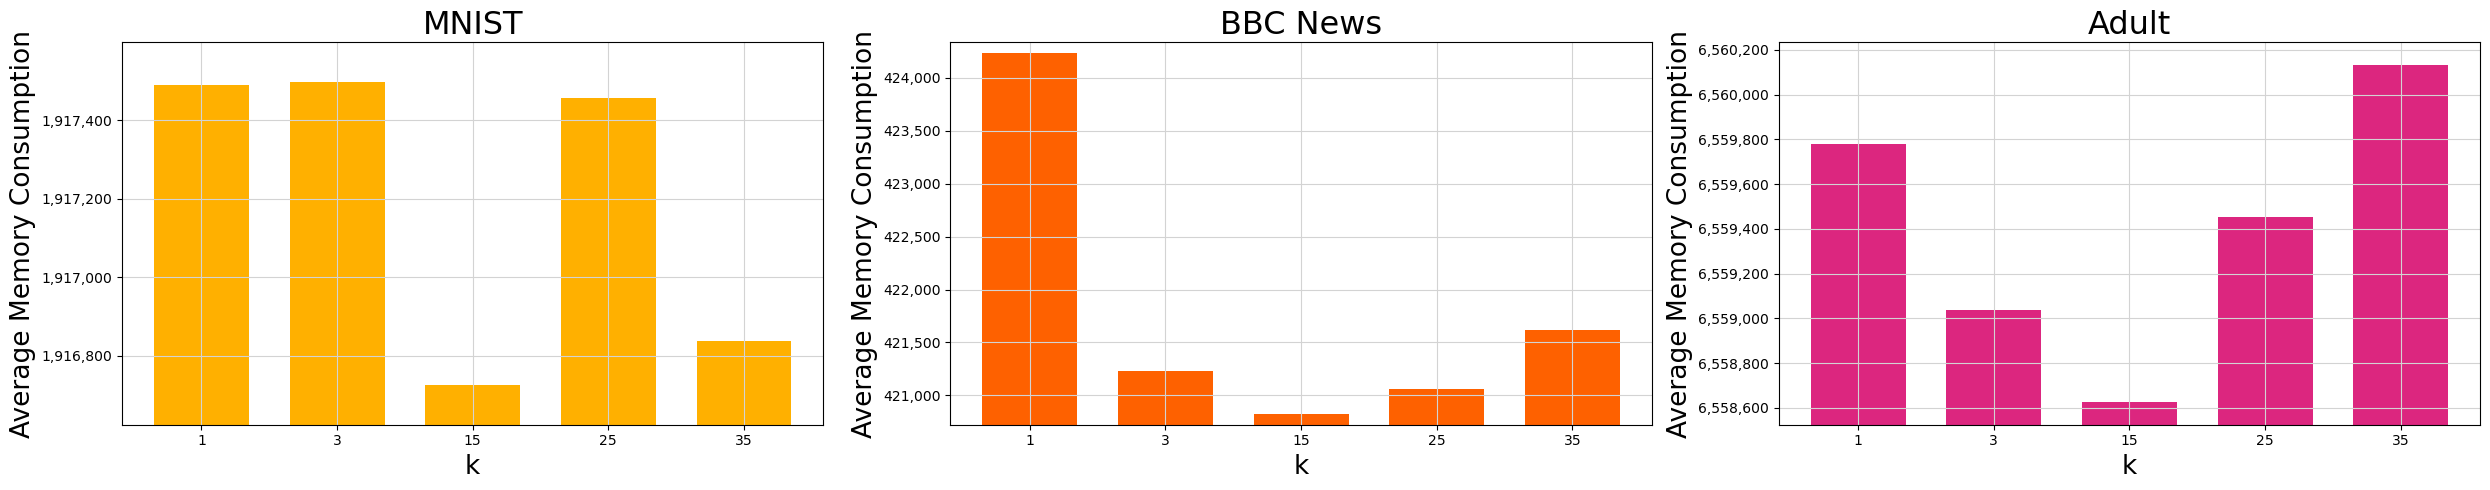

In [35]:
plot_mem(real_mems, new_ks, titles)